# Check the MLM performance of the pre-trained model on different languages

__Obejctive:__ show that switching to languages it hasn't seen before, the pre-trained model's performance actually degrades.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('../../modules/')

from logger_tree_language import get_logger
from pytorch_utilities import load_checkpoint
from plotting import plot_training_history
from masked_language_modeling import mask_sequences

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logger = get_logger('check_mlm_performance')

In [2]:
PRETRAINING_DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_4_8_1.0_0.00000.npy'
DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_validation_4_8_1.0_0.00000.npy'
MODEL_DIR = '../../models/mlm_pretraining_2/'

## MLM accuracy on different languages and for different masking rates

Load pretrained model.

In [3]:
checkpoint_epochs = sorted([
    int(f.split('_')[-1].split('.')[0])
    for f in os.listdir(MODEL_DIR)
    if '.pt' in f
])

selected_checkpoint_epoch = checkpoint_epochs[-1]

checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

logger.info(f'Selected checkpoint: {checkpoint_id}')

pretrained_model, _, pretraining_history = load_checkpoint(
    MODEL_DIR,
    checkpoint_id,
    device=device
)

2024-05-20 15:26:58,916 - check_mlm_performance - INFO - Selected checkpoint: mlm_pretraining_2_epoch_2000.pt
/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


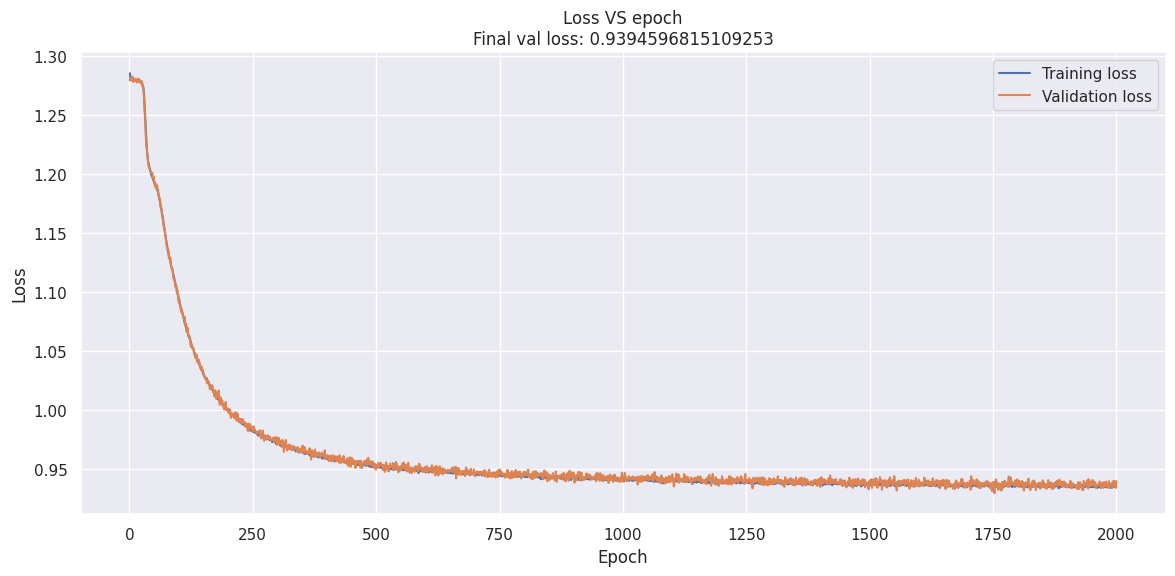

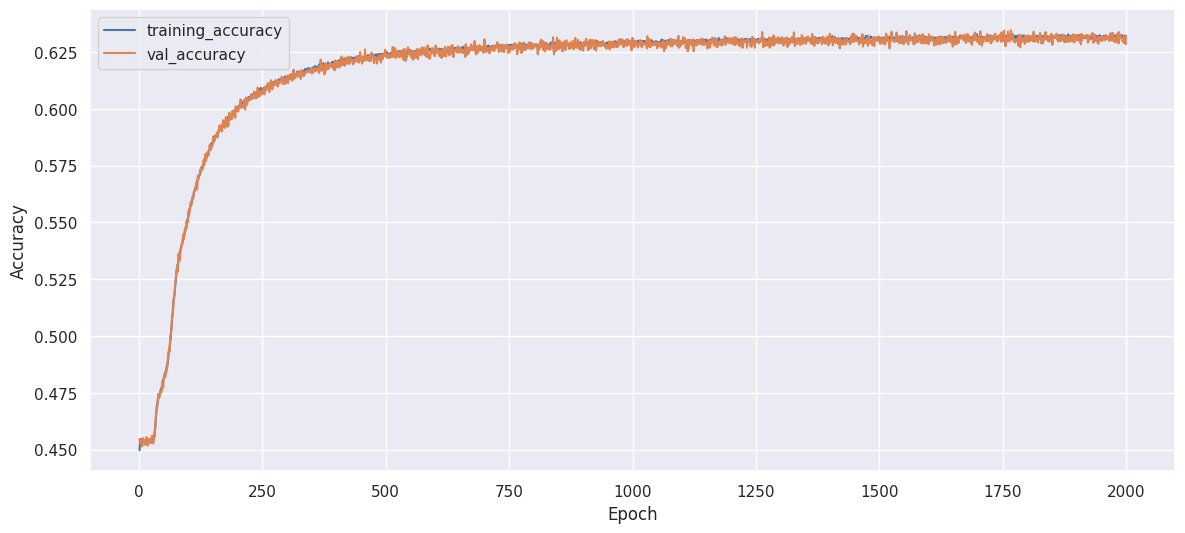

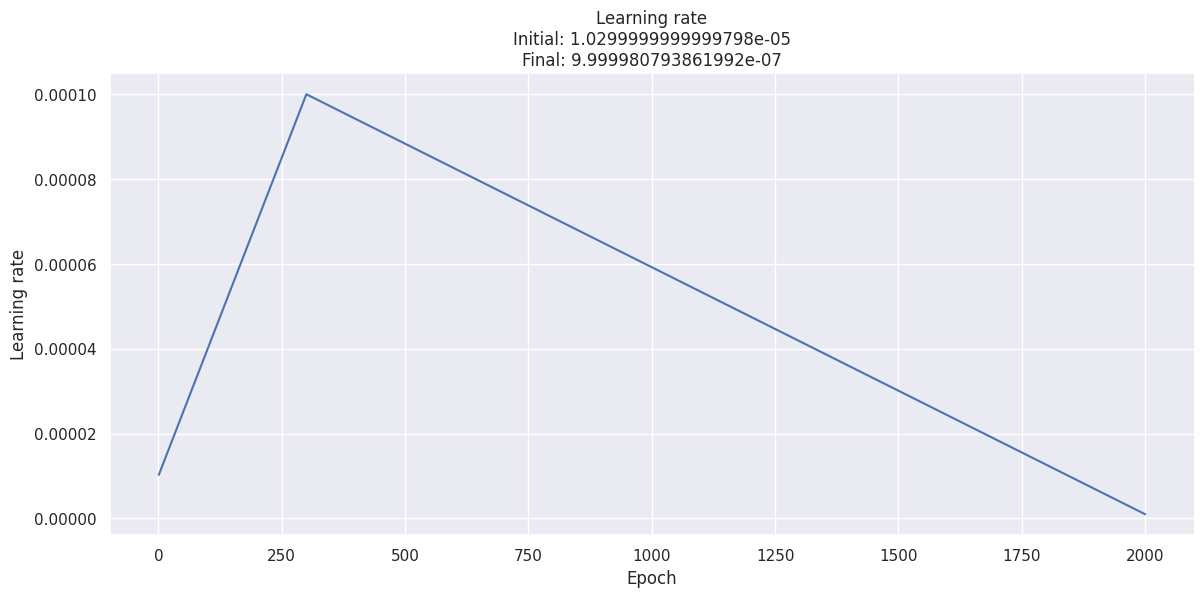

In [4]:
plot_training_history(pretraining_history)

Load data.

In [5]:
mlm_accuracies = []

In [6]:
q, k, sigma, epsilon, _, leaves_seeds, _ = np.load(DATA_PATH, allow_pickle=True)

vocab = torch.arange(q).to(dtype=torch.int64)
mask_idx = vocab.max() + 1

n_samples_test = 5000

reshaped_mask_idx = reshaped_mask_idx = (
    mask_idx.repeat(leaves_seeds[..., 0].T[:n_samples_test, ...].shape).to(device=device)
)

# The last index corresponds to the seed that generated the
# data/transition tensors: select one.
for mask_rate in [0.1, 0.25, 0.50, 0.75, 0.95]:
    for seed in range(leaves_seeds.shape[-1]):
        logger.info(f'MLM on seed: {seed} | Mask rate: {mask_rate}')
        
        # Load the data on which to perform the check.
        shuffled_indices = np.random.choice(range(leaves_seeds.shape[1]), leaves_seeds.shape[1], replace=False)
        
        leaves = leaves_seeds[..., seed].T
        leaves = leaves[shuffled_indices, :]
        
        # Select a samples to test upon.
        leaves_test = leaves[-n_samples_test:, :]
        
        # Data preprocessing.
        leaves_test = torch.from_numpy(leaves_test).to(device=device).to(dtype=torch.int64)
    
        # Evaluate MLM performance on the data.
        # Mask the sequences.
        masked_sequences, mask = mask_sequences(
            sequences=leaves_test[:n_samples_test, ...],
            mask_rate=mask_rate,
            reshaped_mask_idx=reshaped_mask_idx,
            device=device
        )
    
        # Compute model's predictions.
        pred = pretrained_model(masked_sequences).detach()
    
        # Compute the accuracy on the prediction of the masked leaves.
        mlm_accuracy = (torch.argmax(pred, dim=-1) == leaves_test[:n_samples_test, ...])[mask].to(dtype=torch.float64).mean()
    
        mlm_accuracies.append({
            'seed': seed,
            'mlm_accuracy': float(mlm_accuracy.cpu().numpy()),
            'mask_rate': mask_rate
        })

mlm_accuracies_df = pd.DataFrame(mlm_accuracies)

2024-05-20 15:27:01,076 - check_mlm_performance - INFO - MLM on seed: 0 | Mask rate: 0.1
2024-05-20 15:27:01,549 - check_mlm_performance - INFO - MLM on seed: 1 | Mask rate: 0.1
2024-05-20 15:27:01,908 - check_mlm_performance - INFO - MLM on seed: 2 | Mask rate: 0.1
2024-05-20 15:27:02,268 - check_mlm_performance - INFO - MLM on seed: 3 | Mask rate: 0.1
2024-05-20 15:27:02,627 - check_mlm_performance - INFO - MLM on seed: 4 | Mask rate: 0.1
2024-05-20 15:27:02,987 - check_mlm_performance - INFO - MLM on seed: 5 | Mask rate: 0.1
2024-05-20 15:27:03,346 - check_mlm_performance - INFO - MLM on seed: 6 | Mask rate: 0.1
2024-05-20 15:27:03,706 - check_mlm_performance - INFO - MLM on seed: 7 | Mask rate: 0.1
2024-05-20 15:27:04,067 - check_mlm_performance - INFO - MLM on seed: 8 | Mask rate: 0.1
2024-05-20 15:27:04,426 - check_mlm_performance - INFO - MLM on seed: 9 | Mask rate: 0.1
2024-05-20 15:27:04,786 - check_mlm_performance - INFO - MLM on seed: 10 | Mask rate: 0.1
2024-05-20 15:27:05,

/tmp/ipykernel_79258/3438319887.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(


<Axes: xlabel='seed', ylabel='mlm_accuracy'>

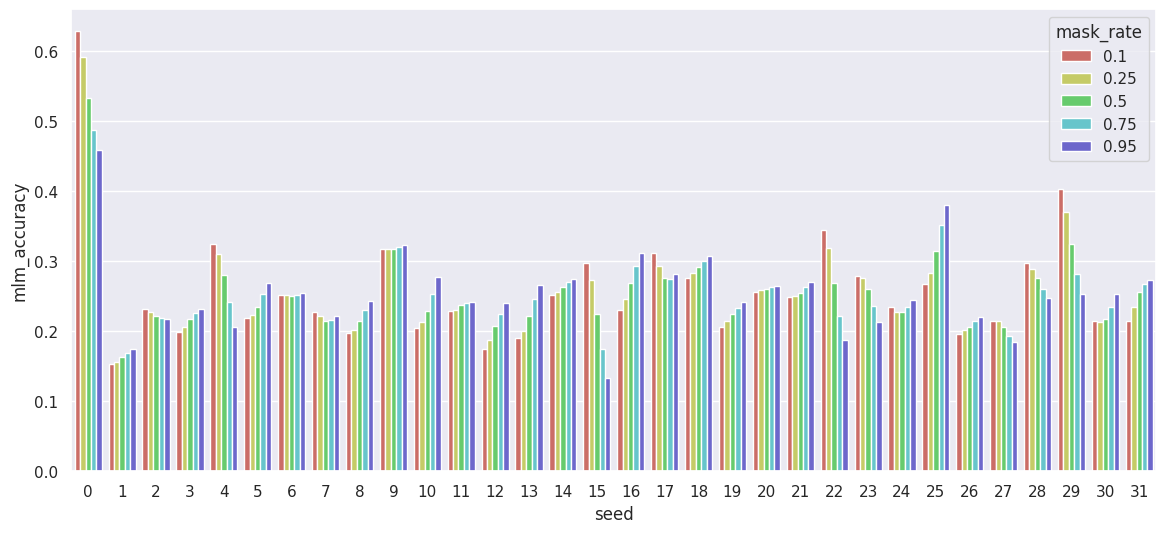

In [7]:
fig = plt.figure(figsize=(14, 6))

sns.barplot(
    x=mlm_accuracies_df['seed'],
    y=mlm_accuracies_df['mlm_accuracy'],
    hue=mlm_accuracies_df['mask_rate'],
    palette=sns.color_palette('hls')
)

**Observation:** the model seems to work way better on the language it was pre-trained upon, even in a regime of very high masking rate (~95% of the symbols masked). This is because the model understood something about some general census characteristic of the language: when many symbols are masked, it tends to predict mostly the same symbol, which turns out to be the most represented one in the language.

To show this:
- Load the leaves from the original language.
- Given a fully-masked sequence, get the symbol the model predicts the most for that sequence.
- Build a fake prediction in which the most predicted symbol (above) is repeated in all positions.
- Compare the fake prediction with the one leaves from the original language.

If the guess is correct (the model exploits some census characteristic), then the accuracy of the fake prediction in predicting the leaves from the original language is above $1/q$, and is actually comparable with the performance of the model in a high masking rate regime.

In [86]:
q, k, sigma, epsilon, roots_seeds, leaves_seeds, rho_seeds = np.load(DATA_PATH, allow_pickle=True)

seed_pretraining_language = 0

# Load the data on which to perform the check.
shuffled_indices = np.random.choice(range(leaves_seeds.shape[1]), leaves_seeds.shape[1], replace=False)

roots = roots_seeds[:, seed]
roots = roots[shuffled_indices]

leaves = leaves_seeds[..., seed_pretraining_language].T
leaves = leaves[shuffled_indices, :]

# Select a samples to test upon.
leaves_test = leaves[-n_samples_test:, :]
roots_test = roots[-n_samples_test:]

# Data preprocessing.
leaves_test = torch.from_numpy(leaves_test).to(device=device).to(dtype=torch.int64)
roots_test = torch.from_numpy(roots_test).to(device=device).to(dtype=torch.int64)

In [91]:
# Check: distribution of the roots.
np.unique(
    roots_test.detach().cpu().numpy(),
    return_counts=True
)

(array([0, 1, 2, 3]), array([1197, 1206, 1313, 1284]))

In [9]:
# Get the symbol the model predicts the most when all the input
# symbols are masked.
values, counts = np.unique(
    torch.argmax(pretrained_model(reshaped_mask_idx[:1, ...]), dim=-1).detach().cpu().numpy(),
    return_counts=True
)

most_predicted_symbol = values[np.argsort(counts)[::-1]][0]

# Generate a fake prediction made of only the most predicted symbol,
# repeated in all positions.
census_pred = torch.from_numpy(np.array(most_predicted_symbol)).repeat(leaves_test.shape).to(device=device)

# Compare the fake, constant prediction with the actual sequences,
# and compute how often the symbol predicted this way agrees with
# the actual one.
(census_pred == leaves_test).to(dtype=torch.float64).mean(dim=-1).mean()

tensor(0.4538, device='cuda:0', dtype=torch.float64)

In [10]:
mlm_accuracies_df[
    (mlm_accuracies_df['seed'] == 0)
    & (mlm_accuracies_df['mask_rate'] == mlm_accuracies_df['mask_rate'].max())
]

,seed,mlm_accuracy,mask_rate
128,0,0.459193,0.95


## Investigate the "constant prediction" regime

When an all-masked sequence is fed as input, the model tends to generate a constant prediction (same symbol for almost all the positions in the sequence). Question:
- Does this regime kick when the masking rate is above a threshold value?
- Does the model in fact predict always the same symbol for masked positions?

In [79]:
predicted_masked_symbols_data = []

for mask_rate in [0.1, 0.25, 0.50, 0.75, 0.95, 1.]:
    masked_sequences, mask = mask_sequences(
        sequences=leaves_test[:n_samples_test, ...],
        mask_rate=mask_rate,
        reshaped_mask_idx=reshaped_mask_idx,
        device=device
    )

    # Compute model's predictions.
    pred = pretrained_model(masked_sequences).detach()

    predicted_masked_symbols, symbol_counts = np.unique(
        torch.argmax(pred, dim=-1)[mask].cpu().numpy(),
        return_counts=True
    )

    # Sort the counts by symbol label (0 to q).
    symbol_counts = symbol_counts[predicted_masked_symbols.argsort()]

    symbol_frequencies = symbol_counts / symbol_counts.sum()

    predicted_masked_symbols_data.append(pd.DataFrame({
        'symbol': predicted_masked_symbols,
        'symbol_frequency': symbol_frequencies,
        'mask_rate': mask_rate
    }))

predicted_masked_symbols_data = pd.concat(predicted_masked_symbols_data).reset_index(drop=True)

Text(0.5, 1.0, 'Frequency of symbols predicted for masked positions')

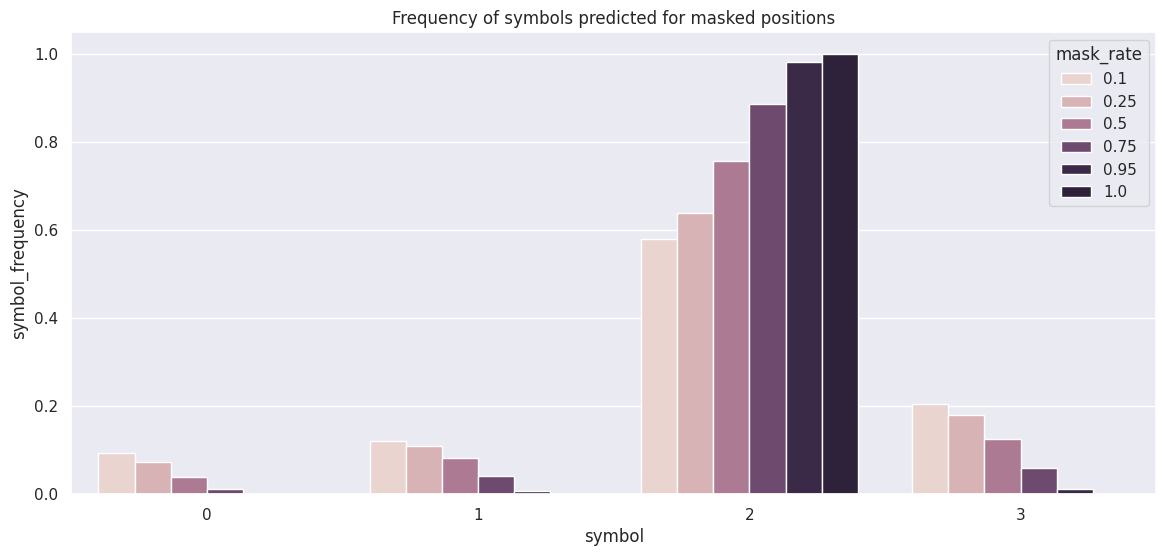

In [85]:
fig = plt.figure(figsize=(14, 6))

sns.barplot(
    x=predicted_masked_symbols_data['symbol'],
    y=predicted_masked_symbols_data['symbol_frequency'],
    hue=predicted_masked_symbols_data['mask_rate']
)

plt.title('Frequency of symbols predicted for masked positions')